In [1]:
import networkx as nx
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
TOP_K = 3 # a quatidade de nós/documentos principais a serem retornados
MIN_SIM = 0.7 # o mínimo de similaridade aceitável na aplicação
documents = [
    "Clientes podem pagar com cartão de crédito em até 6 vezes sem juros.",
    "Aceitamos Pix como forma de pagamento instantâneo.",
    "Compras com boleto bancário podem levar até 3 dias úteis para compensação.",
    "Para pagar com cartão de débito, selecione a opção no checkout.",
    "Os pagamentos com cartão passam por análise antifraude automática.",
    "Nosso site é o http://xuxu.com.br",
    "Compras são feitas pelo nosso site e enviamos para todo Brasil.",
    
    "Trocas são aceitas em até 7 dias após o recebimento do produto.",
    "Para iniciar uma devolução, acesse sua conta e selecione a compra.",
    "O produto precisa estar sem sinais de uso e com embalagem original.",
    "A primeira troca é gratuita, exceto em produtos promocionais.",
    "O reembolso será feito após análise do item devolvido, em até 10 dias.",
    
    "Entregamos para todo o Brasil com prazo de 3 a 10 dias úteis.",
    "Frete grátis disponível para compras acima de R$200.",
    "Você pode acompanhar seu pedido usando o código de rastreamento enviado por e-mail.",
    "Pedidos com problemas de entrega devem ser informados ao suporte.",
    "Ajustes no endereço só são aceitos antes da confirmação do envio.",
    
    "Os sapatos da linha esportiva são ideais para academia e caminhadas.",
    "A linha social oferece modelos elegantes para eventos e trabalho.",
    "Nossos calçados veganos não utilizam nenhum material de origem animal.",
    "Modelos em couro legítimo recebem tratamento especial contra ressecamento.",
    "Palmilhas e cadarços estão disponíveis como acessórios avulsos."
]

In [3]:
def get_embedding(texts):
    # Envia os textos para a API local do modelo de embedding (nomic-embed-text)
    response = requests.post(
        "http://localhost:11434/api/embed",
        json={"model": "nomic-embed-text", "input": texts}
    )
    
    # Garante que a resposta foi bem-sucedida, senão lança um erro
    response.raise_for_status()
    
    # Extrai os vetores da resposta e converte para um array NumPy
    vectors = np.array(response.json()["embeddings"])
    
    # Normaliza os vetores para ter norma 1
    return vectors / np.linalg.norm(vectors, axis=1, keepdims=True)

# Gera e armazena os embeddings normalizados de todos os documentos
embeddings = get_embedding(documents)

In [4]:
# Cria um grafo não direcionado vazio usando NetworkX
graph = nx.Graph()

# Adiciona cada documento como um nó no grafo, usando o índice do laço como ID e o texto como atributo
for i, doc in enumerate(documents):
    graph.add_node(i, text=doc)

In [5]:
# Laço duplo para comparar todos os pares de documentos e montar as arestas do grafo
for i in range(len(documents)):
    for j in range(i + 1, len(documents)):  # Evita repetir comparações e auto-similaridade
        sim = np.dot(embeddings[i], embeddings[j]) # calcula a similaridade entre dois vetores
        if sim >= MIN_SIM:  # Cria aresta apenas se a similaridade for maior ou igual ao limiar definido
            graph.add_edge(i, j, weight=sim)

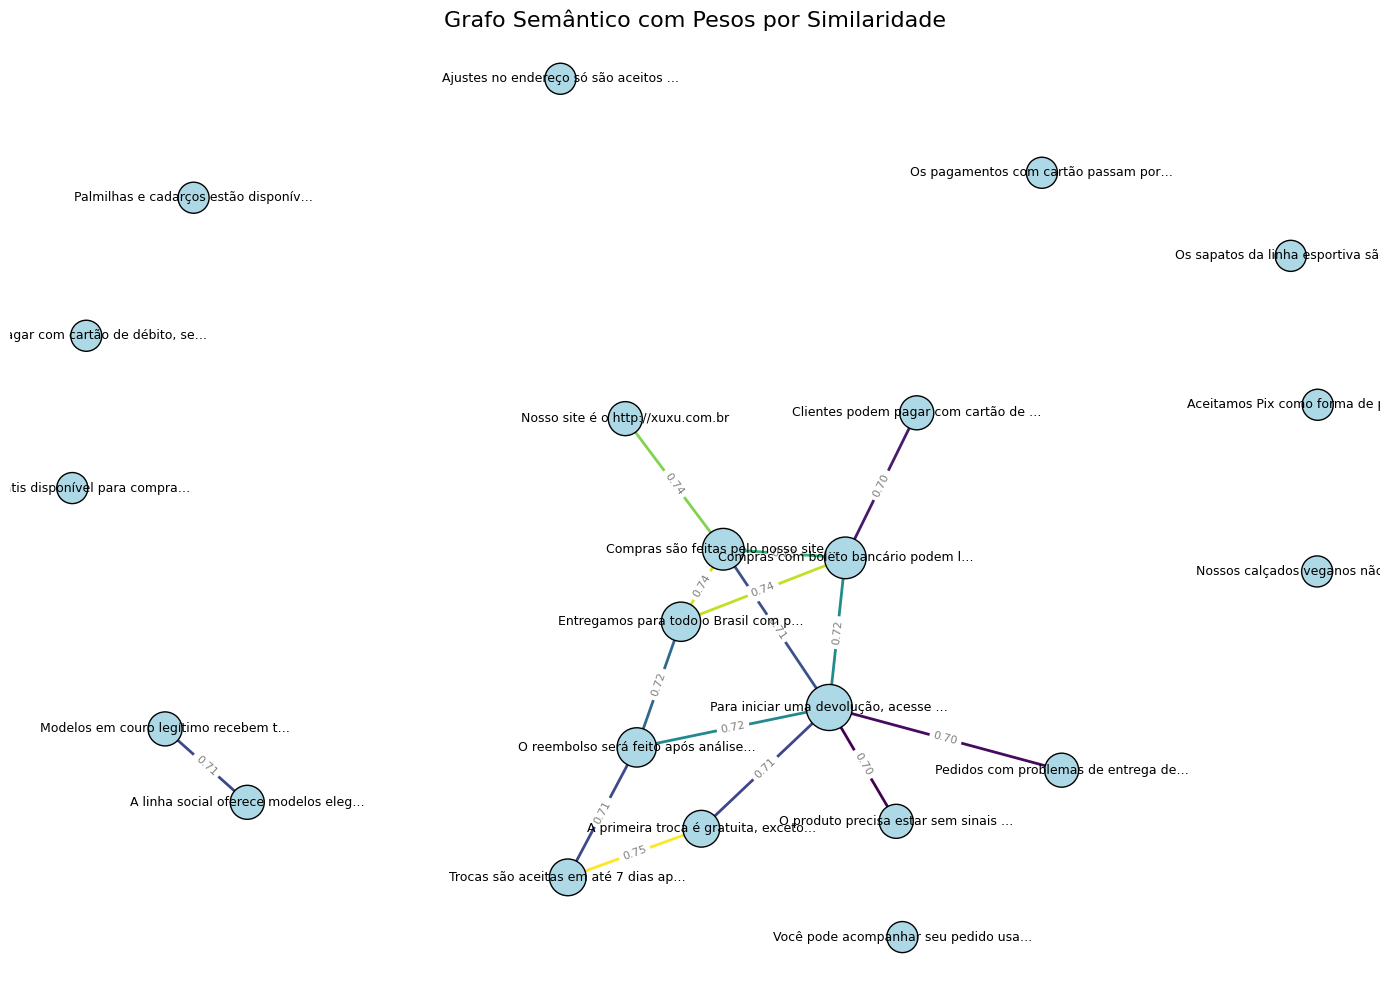

In [7]:
def plot_graph(graph):
    plt.figure(figsize=(14, 10))  # Define o tamanho da figura
    pos = nx.spring_layout(graph, seed=42, k=0.5)  # Calcula posições dos nós com layout de mola

    # Calcula o grau de cada nó e ajusta o tamanho dos nós proporcionalmente
    degrees = dict(graph.degree())
    node_sizes = [500 + 100 * degrees[n] for n in graph.nodes()]

    # Coleta pesos das arestas para definir cores
    edges = graph.edges(data=True)
    weights = [attr['weight'] for _, _, attr in edges]
    min_w, max_w = min(weights), max(weights)
    edge_colors = [plt.cm.viridis((w - min_w) / (max_w - min_w)) for w in weights]

    # Limita o texto exibido em cada nó a 35 caracteres
    labels = {
        i: (graph.nodes[i]["text"][:35] + "…") if len(graph.nodes[i]["text"]) > 35 else graph.nodes[i]["text"]
        for i in graph.nodes()
    }

    # Desenha os nós
    nx.draw_networkx_nodes(graph, pos, node_size=node_sizes, node_color='lightblue', edgecolors='black')

    # Desenha os rótulos dos nós
    nx.draw_networkx_labels(graph, pos, labels, font_size=9)

    # Desenha as arestas com cores baseadas no peso
    nx.draw_networkx_edges(graph, pos, edge_color=edge_colors, width=2)

    # Adiciona rótulos de peso nas arestas
    edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in edges}
    nx.draw_networkx_edge_labels(graph, pos, edge_labels, font_color='gray', font_size=8)

    # Título e layout
    plt.title("Grafo Semântico com Pesos por Similaridade", fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
plot_graph(graph)

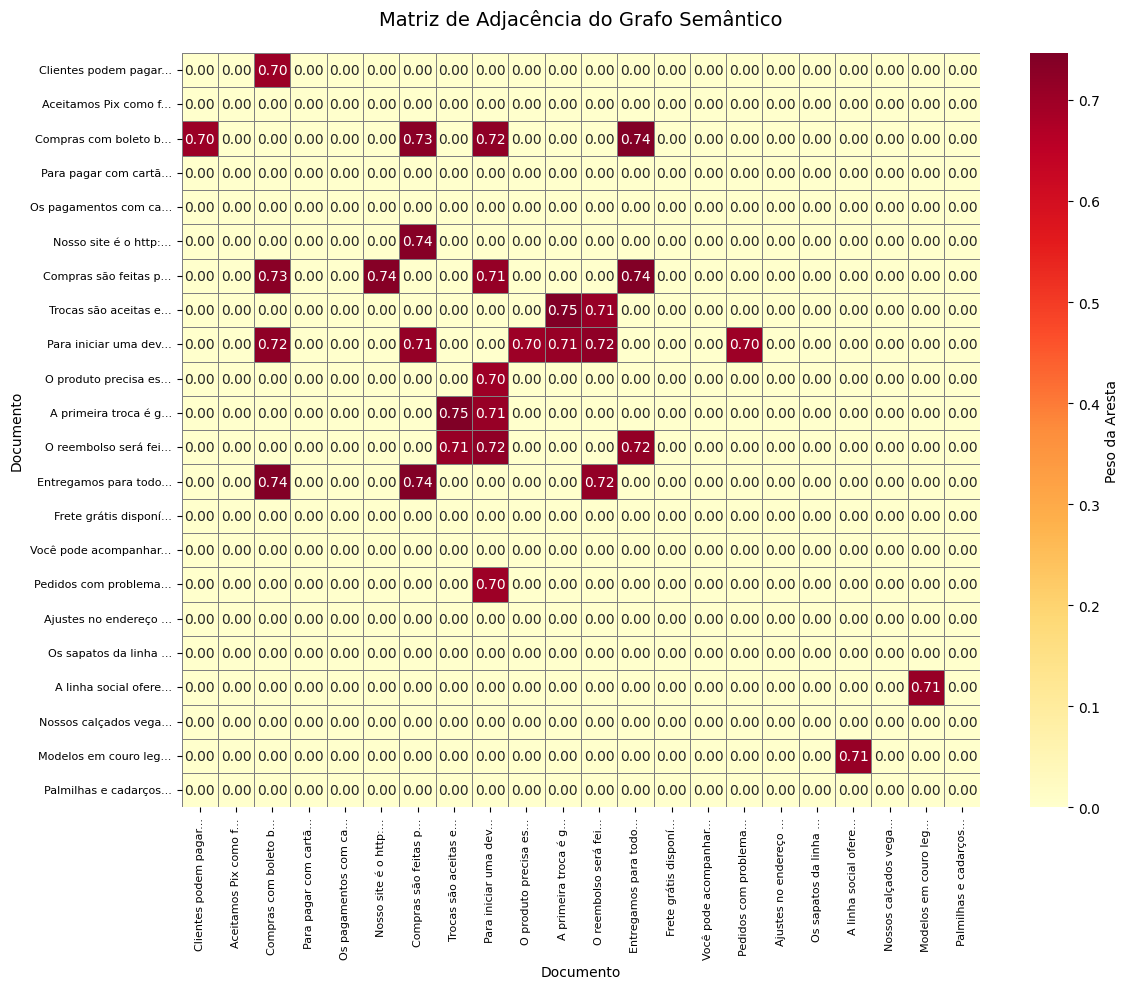

In [8]:
def plot_graph_adjacency_matrix(graph):
    adj = nx.to_numpy_array(graph, weight='weight')
    num_nodes = graph.number_of_nodes()

    # Gera os rótulos com o início do texto de cada documento
    labels = [graph.nodes[i]['text'][:20] + '...' if len(graph.nodes[i]['text']) > 20 else graph.nodes[i]['text'] 
              for i in range(num_nodes)]
    plt.figure(figsize=(12, 10))
    ax = sns.heatmap(
        adj, 
        cmap='YlOrRd',  # paleta de cor em tons quentes
        annot=True,      # mostra os valores dentro das células
        fmt=".2f",       # formatação com 2 casas decimais
        cbar_kws={'label': 'Peso da Aresta'},
        xticklabels=labels,
        yticklabels=labels,
        linewidths=0.5,
        linecolor='gray'
    )
    plt.xticks(rotation=90, fontsize=8)
    plt.yticks(rotation=0, fontsize=8)
    plt.title('Matriz de Adjacência do Grafo Semântico', fontsize=14, pad=20)
    plt.xlabel('Documento')
    plt.ylabel('Documento')
    plt.tight_layout()
    plt.show()
    
plot_graph_adjacency_matrix(graph)

In [9]:
def rag_query(query, top_k=TOP_K, min_edge_weight=MIN_SIM):
    query_emb = get_embedding([query])[0]
    similarities = [np.dot(query_emb, doc_emb) for doc_emb in embeddings]

    # Top K documentos mais similares à query
    top_k_indices = np.argsort(similarities)[::-1][:top_k]

    # Coleta nós principais + seus vizinhos
    context_ids = set()
    for idx in top_k_indices:
        context_ids.add(idx)
        for neighbor in graph.neighbors(idx):
            if graph[idx][neighbor]['weight'] >= min_edge_weight:
                context_ids.add(neighbor)

    # Coleta os textos correspondentes
    context = [graph.nodes[i]['text'] for i in context_ids]

    print(f"\n🔎 Resultado da busca com grafo (sementes = {list(top_k_indices)}):")
    for i in context_ids:
        print(f"- {graph.nodes[i]['text']}")

    return "\n".join(context)

In [10]:
def generate_response(prompt):
    payload = {
        "model": "llama3",
        "prompt": prompt,
        "stream": False,
    } # payload para envio ao Ollama
    response = requests.post("http://localhost:11434/api/generate", json=payload) # post com o prompt
    response.raise_for_status() # retorna um erro em caso de insucesso na requisição
    return response.json()["response"] # retorna apenas a resposta do modelo

In [11]:
query = "É possível fazer Alterações no endereço depois de finalizar a compra? Se sim, como fazer?"

In [12]:
context = rag_query(query)


🔎 Resultado da busca com grafo (sementes = [np.int64(8), np.int64(16), np.int64(9)]):
- Compras com boleto bancário podem levar até 3 dias úteis para compensação.
- Compras são feitas pelo nosso site e enviamos para todo Brasil.
- Para iniciar uma devolução, acesse sua conta e selecione a compra.
- O produto precisa estar sem sinais de uso e com embalagem original.
- A primeira troca é gratuita, exceto em produtos promocionais.
- O reembolso será feito após análise do item devolvido, em até 10 dias.
- Pedidos com problemas de entrega devem ser informados ao suporte.
- Ajustes no endereço só são aceitos antes da confirmação do envio.


In [13]:
full_prompt = f"""
Você é empresa Xuxu.
Você responde **apenas** a perguntas sobre você.
**Nunca** responde sobre perguntas relacionadas a outras empresas. 
**Nunca** inventa informações, dados ou qualquer coisa que não esteja no cotexto que você recebeu. 
Se o contexto recebido for igual a "Nenhum contexto relevante encontrado.", **informe** **apenas** que não tem conhecimento suficiente para responder.
Use o contexto abaixo para responder à pergunta:
{context}
Pergunta: {query}
Resposta:"""

In [14]:
print("\nResposta gerada:")
print(generate_response(full_prompt))


Resposta gerada:
De acordo com o contexto que você forneceu, não é possível fazer ajustes no endereço após finalizar a compra. O contexto menciona que "Ajustes no endereço só são aceitos antes da confirmação do envio." Isso significa que os ajustes de endereço devem ser feitos anteriormente à confirmação do envio, e não após a finalização da compra.
